In [1]:
# ## un-comment out if running locally

# import os
# os.chdir('../')

In [2]:
## if running locally, comment out the following code

!git clone https://github.com/nicktfranklin/SEM3.git
import os
os.chdir('./SEM3/')


In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from core.event_models import *
from core.sem import *
from sklearn import metrics

TensorFlow Version: 1.14.0
TensorFlow Check Passed


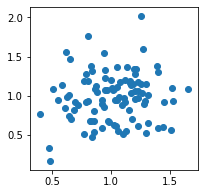

In [4]:
def build_2d_data(N, beta=0.1):
    """ 
    2d, Mulitvariate Guassian data
    """
    mu = [1, 1]
    Sigma = np.eye(2) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N):
        x[n, :] = np.random.multivariate_normal(mu, Sigma)
        
    return x
X = build_2d_data(100)
plt.figure(figsize=(3,3))
plt.scatter(X[:,0], X[:, 1])

In [5]:
D = 2
X_train = X[0:-1]; y_train = X[1:]

Now, we define some toy problem

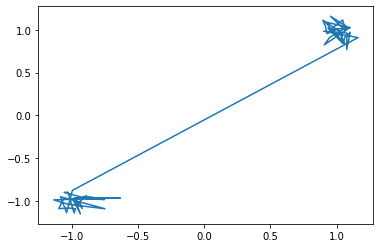

In [6]:
# first demo -- gaussian mixture defined by the CRP

def build_static_dataset(N, beta=0.1):
    """ 
    2 events, modeled as gaussians with different means
    """
    
    pi = np.array([0.4, 0.6])
    mus = [[1, 1], [-1, -1]]
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(int(N/2)):
        x[n, :] = np.random.multivariate_normal(mus[0], np.eye(2) * beta)
    for n in range(int(N/2), N):
        x[n, :] = np.random.multivariate_normal(mus[1], np.eye(2) * beta)
        
    return x

x_train = build_static_dataset(50, 0.01)
y = np.concatenate([np.zeros((25), dtype=int), np.ones((25), dtype=int)])
plt.plot(x_train[:, 0], x_train[:, 1])

In [7]:
# SEM parameters
lmda = 10.0  # stickyness parameter
alfa = .01  # concentration parameter

# prior over the event varaiance 
var_scale = 0.4
var_df = 10

# define plotting function
import seaborn as sns

def plot_segmentation(post, y):
    cluster_id = np.argmax(post, axis=1)
    cc = sns.color_palette('Dark2', post.shape[1])
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
    for clt in cluster_id:
        idx = np.nonzero(cluster_id == clt)[0]
        axes[0].scatter(x_train[idx, 0], x_train[idx, 1], color=cc[clt], alpha=.5)
    axes[0].set_xlabel(r'$\mathbf{x}_{s,1}$')
    axes[0].set_ylabel(r'$\mathbf{x}_{s,2}$')


    axes[1].plot(post)
    y_hat = np.argmax(post, axis=1)
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Cluster ID')
#     print("Adjusted Mutual Information: {}".format(metrics.adjusted_mutual_info_score(y, y_hat)))
    print("Adjusted Rand Score: {}\n".format(metrics.adjusted_rand_score(y, y_hat)))
    print(np.argmax(post, axis=1))

### Linear Events 

W0819 14:29:26.775086 4604155328 deprecation_wrapper.py:119] From /Users/nicholasfranklin/OneDrive/Projects/SEM3/core/sem.py:215: The name tf.keras.backend.set_session is deprecated. Please use tf.compat.v1.keras.backend.set_session instead.

Run SEM:   0%|          | 0/50 [00:00<?, ?it/s]W0819 14:29:26.788278 4604155328 deprecation.py:506] From /Users/nicholasfranklin/anaconda3/envs/sem3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Run SEM: 100%|██████████| 50/50 [00:02<00:00, 20.24it/s]


Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


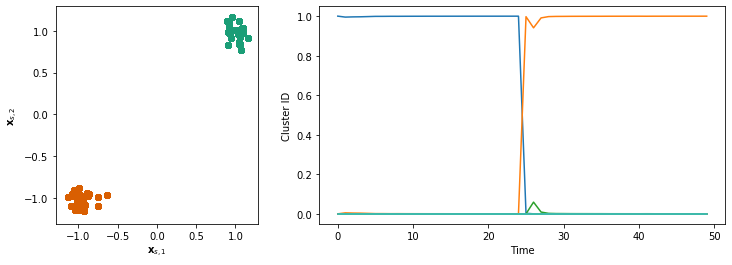

In [8]:
# Initialize keras model
sem_kwargs2 = dict(
    lmda=lmda, alfa=alfa, f_class=LinearEvent, 
    f_opts=dict(var_scale0=var_scale, var_df0=var_df, l2_regularization=0.4)
)

sem2 = SEM(**sem_kwargs2)
post = sem2.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### Non-linear Events

Run SEM: 100%|██████████| 50/50 [00:03<00:00, 16.53it/s]


Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


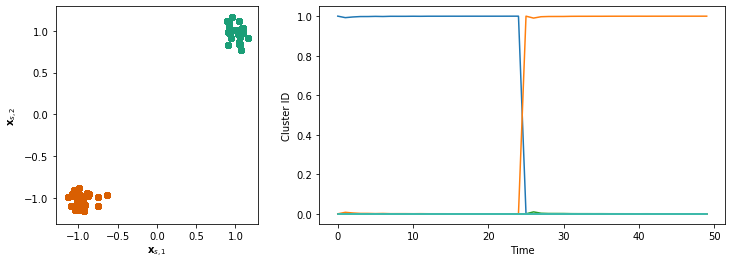

In [9]:
# Initialize keras model
sem_kwargs3 = dict(
    lmda=lmda, alfa=alfa, f_class=NonLinearEvent,
    f_opts=dict(var_scale0=var_scale, var_df0=var_df)
)

sem3 = SEM(**sem_kwargs3)
post = sem3.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

###  Recurrent Linear Events

Run SEM: 100%|██████████| 50/50 [00:03<00:00, 14.43it/s]


Adjusted Rand Score: 0.924751285304133

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2]


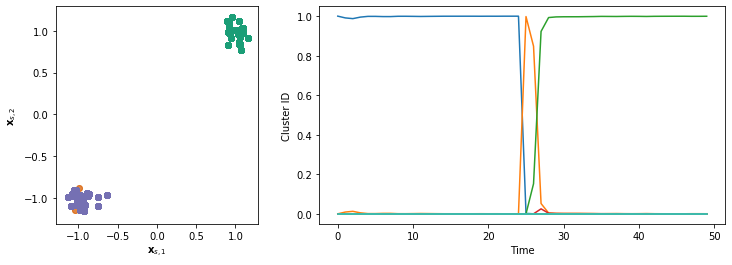

In [10]:
# Initialize keras model
sem_kwargs4 = dict(
    lmda=lmda, alfa=alfa, f_class=RecurentLinearEvent, 
    f_opts=dict(t=3, var_scale0=var_scale, var_df0=var_df)
)

sem4 = SEM(**sem_kwargs4)
post = sem4.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### Recurrent Non-linear Events

Run SEM: 100%|██████████| 50/50 [00:03<00:00, 20.27it/s]


Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


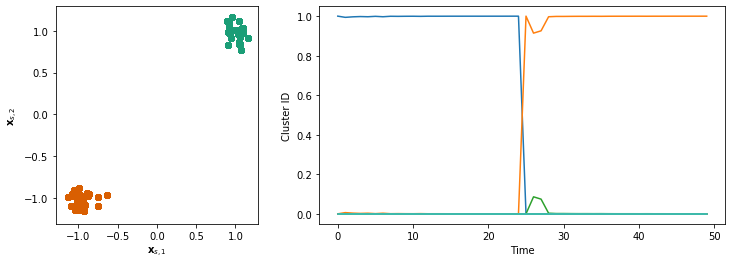

In [11]:
sem_kwargs5 = dict(
    lmda=lmda, alfa=alfa, f_class=RecurrentEvent,
    f_opts=dict(t=3, var_scale0=var_scale, var_df0=var_df)
               )

sem5 = SEM(**sem_kwargs5)
post = sem5.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### Gated Recurrent Unit Events

Run SEM:   0%|          | 0/50 [00:00<?, ?it/s]W0819 14:29:43.758028 4604155328 deprecation.py:323] From /Users/nicholasfranklin/anaconda3/envs/sem3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Run SEM: 100%|██████████| 50/50 [00:06<00:00, 18.19it/s]


Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


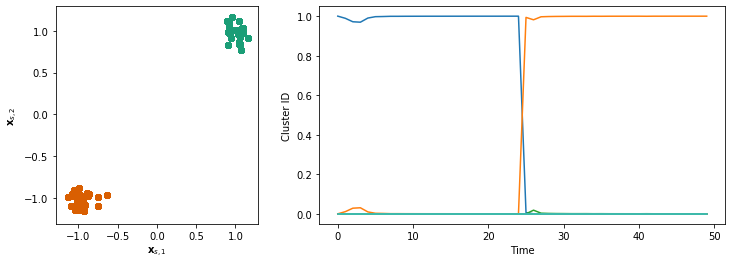

In [12]:
sem_kwargs6 = dict(
    lmda=lmda, alfa=alfa, f_class=GRUEvent,
    f_opts=dict(t=3, var_scale0=var_scale, var_df0=var_df)
               )

sem6 = SEM(**sem_kwargs6)
post = sem6.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### LSTM Events

Run SEM: 100%|██████████| 50/50 [00:08<00:00, 12.73it/s]


Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


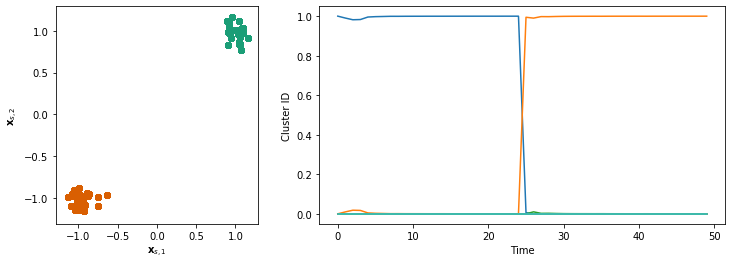

In [13]:
sem_kwargs7 = dict(
    lmda=lmda, alfa=alfa, f_class=LSTMEvent,
    f_opts=dict(t=3, var_scale0=var_scale, var_df0=var_df)
               )

sem7 = SEM(**sem_kwargs7)
post = sem7.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

# Alternating between 2 static events


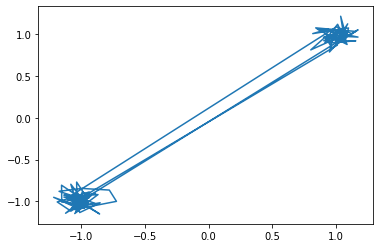

In [14]:
def build_alternating_static_events(N, beta=0.1):
    """ 
    2 alternating events, modeled as gaussians with different means
    """
    
    pi = np.array([0.4, 0.6])
    mus = [[1, 1], [-1, -1]]
    stds = np.ones((2, 2)) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(int(N/4)):
        x[n, :] = np.random.multivariate_normal(mus[0], np.diag(stds[0]))
    for n in range(int(N/4), int(N/2)):
        x[n, :] = np.random.multivariate_normal(mus[1], np.diag(stds[1]))
    for n in range(int(N/2), int(N/4*3)):
        x[n, :] = np.random.multivariate_normal(mus[0], np.diag(stds[0]))
    for n in range(int(N/4*3), N):
        x[n, :] = np.random.multivariate_normal(mus[1], np.diag(stds[1]))
        
    return x

x_train = build_alternating_static_events(100, 0.01)
y = np.concatenate([np.zeros(25, dtype=int), np.ones(25, dtype=int), np.zeros(25, dtype=int), np.ones(25, dtype=int)])
plt.plot(x_train[:, 0], x_train[:, 1])

### Linear Events 

Run SEM: 100%|██████████| 100/100 [00:05<00:00, 17.36it/s]


Adjusted Rand Score: 0.7468030690537084

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


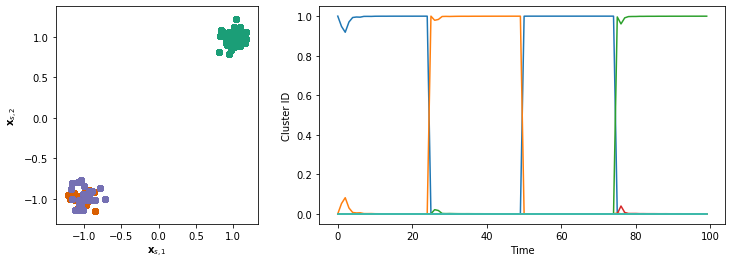

In [15]:
sem2 = SEM(**sem_kwargs2)
post = sem2.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### Non-linear Events

Run SEM: 100%|██████████| 100/100 [00:07<00:00, 13.19it/s]


Adjusted Rand Score: 0.7468030690537084

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


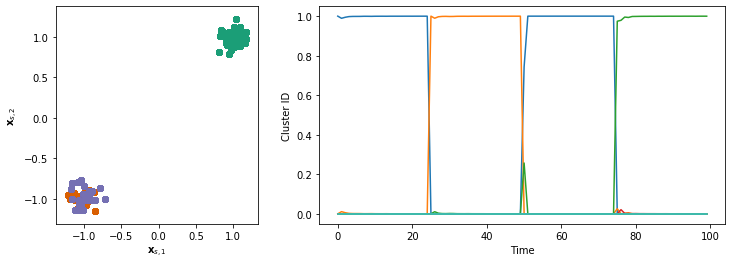

In [16]:
sem3 = SEM(**sem_kwargs3)
post = sem3.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### Recurrent Linear Events

Run SEM: 100%|██████████| 100/100 [00:12<00:00,  8.02it/s]


Adjusted Rand Score: 0.9611929572403881

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


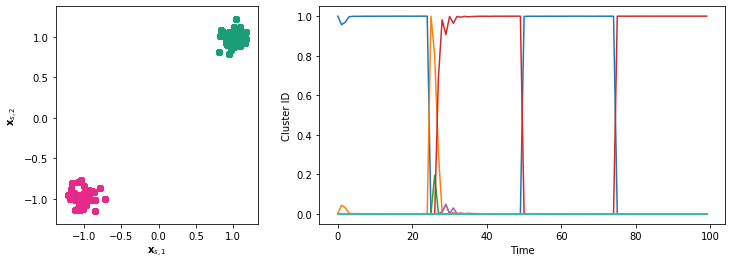

In [17]:
sem4 = SEM(**sem_kwargs4)
post = sem4.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### Recurrent Non-linear Events

Run SEM: 100%|██████████| 100/100 [00:09<00:00, 10.25it/s]


Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


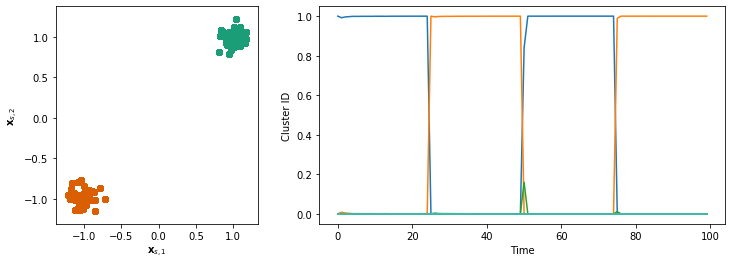

In [18]:
sem5 = SEM(**sem_kwargs5)
post = sem5.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### GRU Events

Run SEM: 100%|██████████| 100/100 [00:14<00:00,  7.06it/s]


Adjusted Rand Score: 0.7468030690537084

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


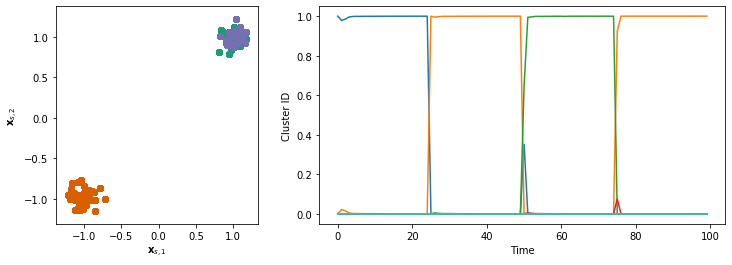

In [19]:
sem6 = SEM(**sem_kwargs6)
post = sem6.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### LSTM Events

Run SEM: 100%|██████████| 100/100 [00:16<00:00, 12.24it/s]


Adjusted Rand Score: 0.4724083183248479

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


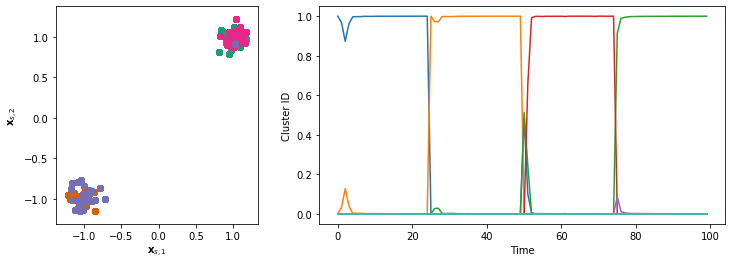

In [20]:
sem7 = SEM(**sem_kwargs7)
post = sem7.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

# Example of four events where the events correspond to movement in vector space

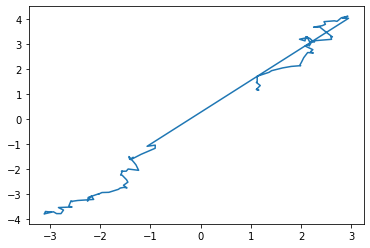

In [21]:
def build_moving_data(N, beta=0.01):
    pi = np.array([0.4, 0.6])
    bs = [[1, 1], [-1, -1]]  # starting point!
    ws = [np.array([[1, 0], [.5, 2]]), np.array([[-1, .2], [-.2, 1]])]
    stds = np.eye(2) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    
    x[0, :] = np.random.multivariate_normal(bs[0], stds)
    for n in range(1, int(N/2)):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, stds)
        
    x[int(N/2), :] = np.random.multivariate_normal(bs[1], stds)
    for n in range(int(N/2+1), N):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, stds)
    return x

x_train = build_moving_data(100)
y = np.concatenate([np.zeros(50, dtype=int), np.ones(50, dtype=int)])
plt.plot(x_train[:, 0], x_train[:, 1])

### Linear Events 

Run SEM: 100%|██████████| 100/100 [00:04<00:00, 32.21it/s]


Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


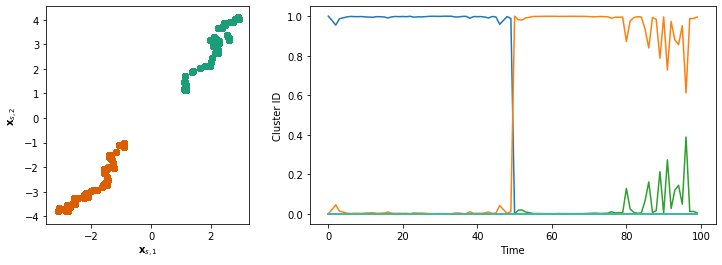

In [22]:
sem2 = SEM(**sem_kwargs2)
post = sem2.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### Non-linear Events

Run SEM: 100%|██████████| 100/100 [00:05<00:00, 19.03it/s]


Adjusted Rand Score: 0.3103101046012207

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  5  6  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  9 10 11 12 13 14 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 14 15 16 17 18 19 20 21 22 23 23 24 24 24 24 24 24 24 24 24 24
 24 24 24 24]


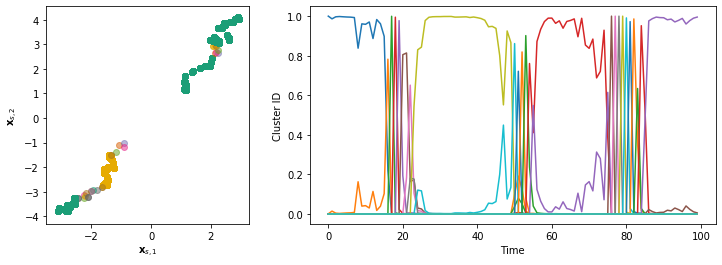

In [23]:
sem3 = SEM(**sem_kwargs3)
post = sem3.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### Recurrent Linear Events

Run SEM: 100%|██████████| 100/100 [00:14<00:00,  8.34it/s]


Adjusted Rand Score: 0.4706664423443867

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 4 5 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]


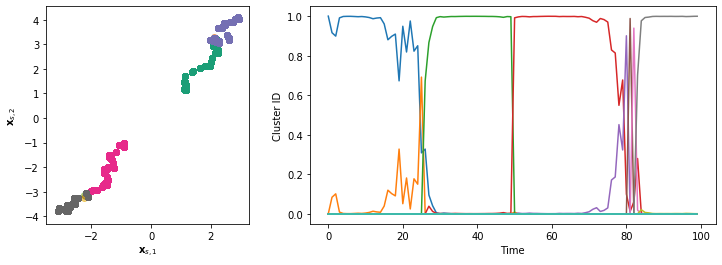

In [24]:
sem4 = SEM(**sem_kwargs4)
post = sem4.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### Recurrent Non-linear Events

Run SEM: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]


Adjusted Rand Score: 0.5630366093053945

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  3  4
  5  6  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  7  7  8
  9 10 11 12]


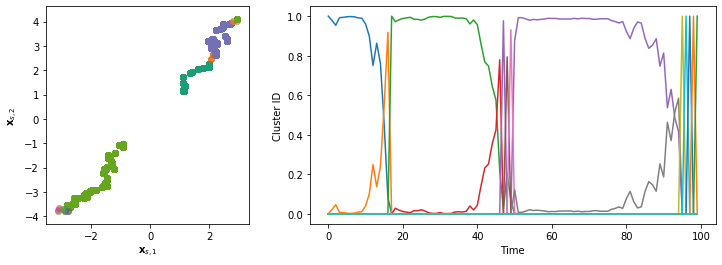

In [25]:
sem5 = SEM(**sem_kwargs5)
post = sem5.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### GRU Events

Run SEM: 100%|██████████| 100/100 [01:21<00:00,  2.45s/it]


Adjusted Rand Score: 0.37315528837862477

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  2  3  4  5  6  7  8
  9 10 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 12 13 14 15 16
 17 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 19 18 18 19 20 21 22 23 24 25
 26 27 28 29]


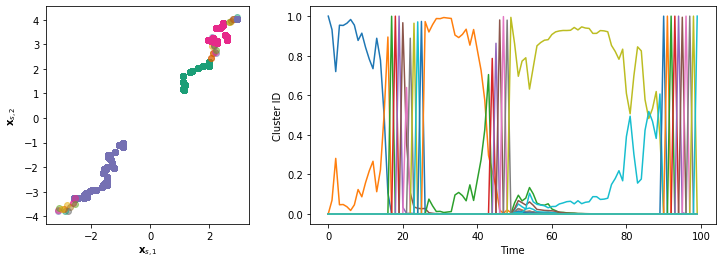

In [26]:
sem6 = SEM(**sem_kwargs6)
post = sem6.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### LSTM Events

Run SEM: 100%|██████████| 100/100 [02:01<00:00,  1.24s/it]


Adjusted Rand Score: 0.45534992676953123

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8
  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32
 33 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34
 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34
 35 36 37 38]


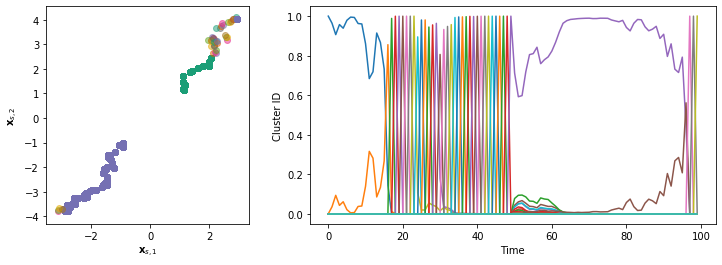

In [27]:
sem7 = SEM(**sem_kwargs7)
post = sem7.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

# Two alternating events with different levels of noise (10x)

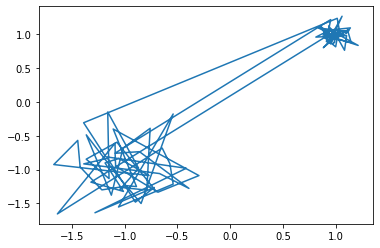

In [30]:
def build_alternating_static_events(N, beta=0.1):
    """ 
    2 alternating events, modeled as gaussians with different means
    """
    
    pi = np.array([0.4, 0.6])
    mus = [[1, 1], [-1, -1]]
    stds = np.array([beta, beta * 10.])
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(int(N/4)):
        x[n, :] = np.random.multivariate_normal(mus[0], np.eye(2) * stds[0])
    for n in range(int(N/4), int(N/2)):
        x[n, :] = np.random.multivariate_normal(mus[1], np.eye(2) * stds[1])
    for n in range(int(N/2), int(N/4*3)):
        x[n, :] = np.random.multivariate_normal(mus[0], np.eye(2) * stds[0])
    for n in range(int(N/4*3), N):
        x[n, :] = np.random.multivariate_normal(mus[1], np.eye(2) * stds[1])
        
    return x

x_train = build_alternating_static_events(100, 0.01)
y = np.concatenate([np.zeros(25, dtype=int), np.ones(25, dtype=int), np.zeros(25, dtype=int), np.ones(25, dtype=int)])
plt.plot(x_train[:, 0], x_train[:, 1])

### Linear Events

Run SEM: 100%|██████████| 100/100 [00:13<00:00,  7.48it/s]


Adjusted Rand Score: 0.707797231853741

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


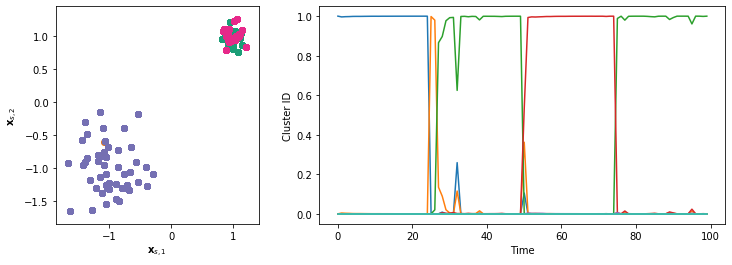

In [31]:
sem2 = SEM(**sem_kwargs2)
post = sem2.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### Non-linear Events

Run SEM: 100%|██████████| 100/100 [00:13<00:00,  7.68it/s]


Adjusted Rand Score: 0.9611929572403881

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


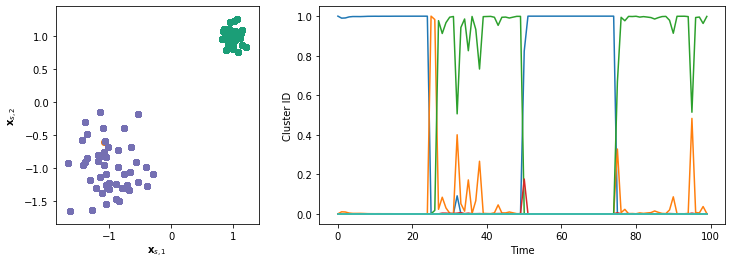

In [32]:
sem3 = SEM(**sem_kwargs3)
post = sem3.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### Recurrent Linear Events

Run SEM: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]


Adjusted Rand Score: 0.9607885571021997

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


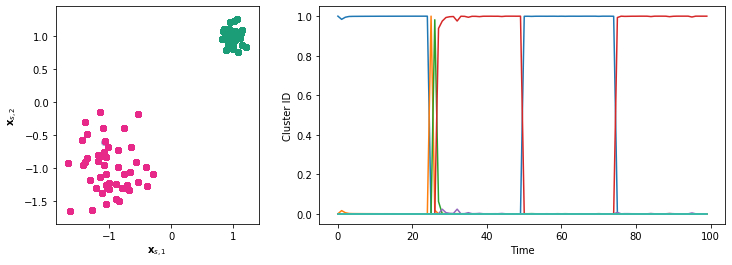

In [33]:
sem4 = SEM(**sem_kwargs4)
post = sem4.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### Recurrent Non-linear Events

Run SEM: 100%|██████████| 100/100 [00:29<00:00, 10.43it/s]


Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


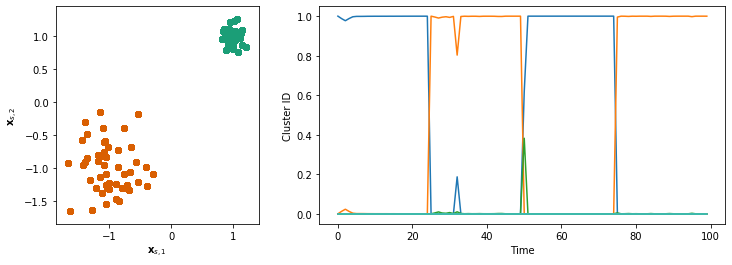

In [34]:
sem5 = SEM(**sem_kwargs5)
post = sem5.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### GRU Events

Run SEM: 100%|██████████| 100/100 [00:37<00:00,  2.65it/s]


Adjusted Rand Score: 0.942991680926574

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


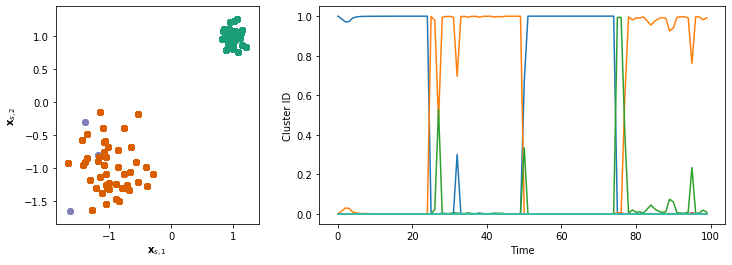

In [35]:
sem6 = SEM(**sem_kwargs6)
post = sem6.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### LSTM Events

Run SEM: 100%|██████████| 100/100 [01:43<00:00,  4.16it/s]


Adjusted Rand Score: 0.9219826301412373

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 0 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


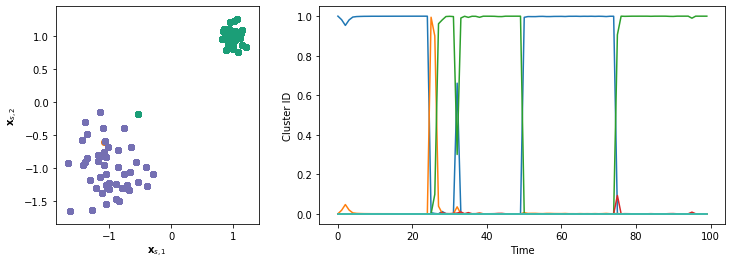

In [36]:
sem7 = SEM(**sem_kwargs7)
post = sem7.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

# 4 events where the events correspond to movement in vector space


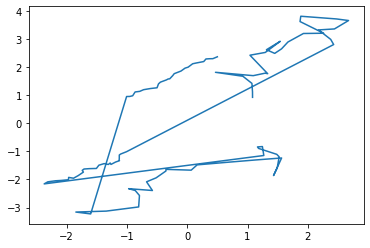

In [37]:
def build_alternating_moving_events(N, beta=0.01):
    pi = np.array([0.4, 0.6])
    bs = [[1, 1], [-1, -1], [1, -1], [-1, 1]]  # starting point!
    ws = [np.array([[1, 0], [.5, 2]]), np.array([[-1, .2], [-.2, 1]])]
    Sigmas = [np.eye(2) * beta* 5.,
            np.eye(2) * beta / 5.,
            np.eye(2) * beta * 5.,
            np.eye(2) * beta / 5.]
    x = np.zeros((N, 2), dtype=np.float32)
    
    x[0, :] = np.random.multivariate_normal(bs[0], Sigmas[0])
    for n in range(1, int(N/4)):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigmas[0])
        
    x[int(N/4), :] = np.random.multivariate_normal(bs[1], Sigmas[1])
    for n in range(int(N/4+1), int(N/2)):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigmas[1])
            
    x[int(N/2), :] = np.random.multivariate_normal(bs[2], Sigmas[2])
    for n in range(int(N/2+1), int(N/4*3)):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigmas[2])
        
    x[int(N/4*3), :] = np.random.multivariate_normal(bs[3], Sigmas[3])
    for n in range(int(N/4*3+1), N):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigmas[3])      
        
    return x

x_train = build_alternating_moving_events(100)
y = np.concatenate([np.zeros(25, dtype=int), np.ones(25, dtype=int), 
                    np.ones(25, dtype=int)*2, np.ones(25, dtype=int)*3])

plt.plot(x_train[:, 0], x_train[:, 1])

### Linear Events

Run SEM: 100%|██████████| 100/100 [00:23<00:00, 11.67it/s]


Adjusted Rand Score: 0.9209594170630503

[0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


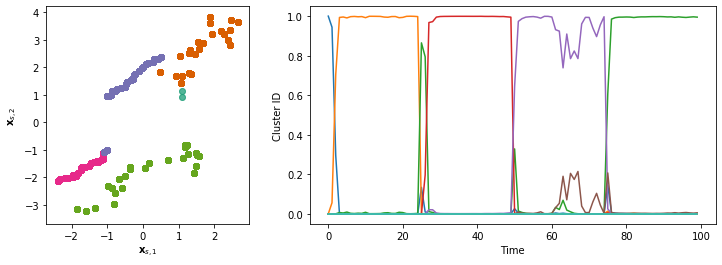

In [38]:
sem2 = SEM(**sem_kwargs2)
post = sem2.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### Non-linear Events

Run SEM: 100%|██████████| 100/100 [00:20<00:00,  4.98it/s]


Adjusted Rand Score: 0.6010675877227413

[ 0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  3  4  5  5
  5  6  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  8  9 10 10 11 12
 13 13 13 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 14 15 15 15 15 15
 15 17 18  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8]


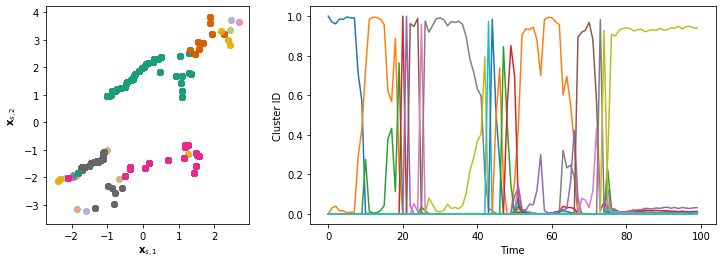

In [39]:
sem3 = SEM(**sem_kwargs3)
post = sem3.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### Recurrent Linear Events

Run SEM: 100%|██████████| 100/100 [01:01<00:00, 10.10it/s]


Adjusted Rand Score: 0.7890291559365377

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 7
 8 7 7 7 7 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


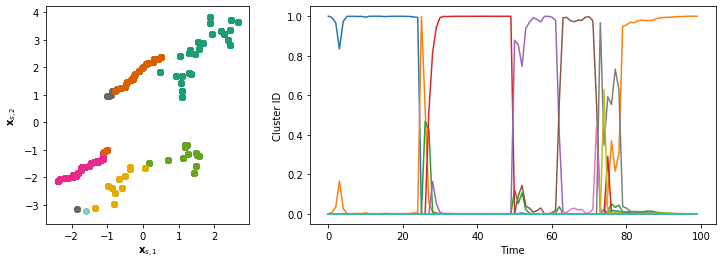

In [40]:
sem4 = SEM(**sem_kwargs4)
post = sem4.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### Recurrent Non-linear Events

Run SEM: 100%|██████████| 100/100 [02:27<00:00,  1.47s/it]


Adjusted Rand Score: 0.49413376723473496

[ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14
 15  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1 13 13 13 13 13 13 13 13 13 13 13 13  1  1  1  1  1  1  1  1  1  1
  1  1  1  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
 11 11 11 11]


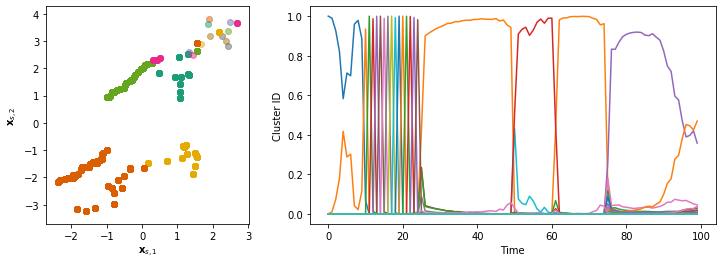

In [41]:
sem5 = SEM(**sem_kwargs5)
post = sem5.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### GRU Events

Run SEM: 100%|██████████| 100/100 [01:49<00:00, 13.13it/s]


Adjusted Rand Score: 0.2381198881871829

[ 0  0  0  0  0  0  0  0  0  0  1  0  0  2  2  2  4  5  6  7  8  9 10 11
 10  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  8  8  8  8  8  8  8  8  8  8  8  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6]


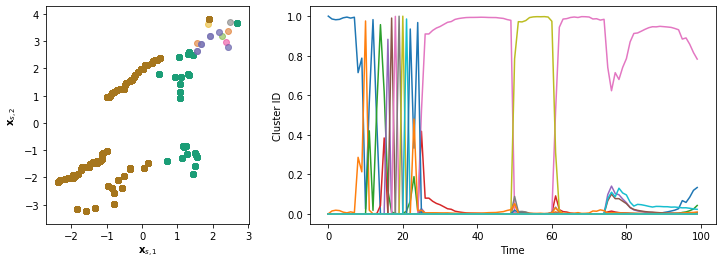

In [42]:
sem5 = SEM(**sem_kwargs5)
post = sem5.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### LSTM Events

Run SEM: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Adjusted Rand Score: 0.2814012202819272

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 3 4 5 6 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


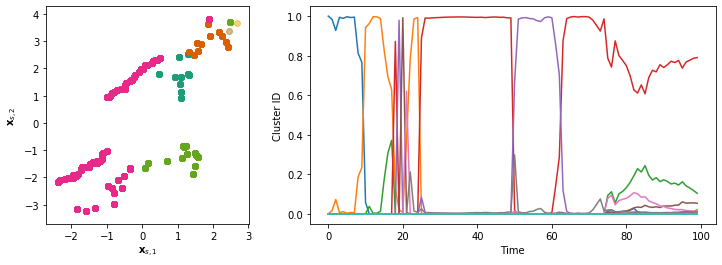

In [43]:
sem5 = SEM(**sem_kwargs5)
post = sem5.run(x_train)
tf.Session().close()
plot_segmentation(post, y)